In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from neuron import NeuronParam, SimpleNeuron
from synapse import Synapse
from encoding import RF_convolution, encode, RF_kernel
from parameter import TrainParam
from STDP import stdp


In [2]:
T = 200
dt = 1
t_pre = -20
t_post = 20


n1 = 28*28 # of neurons in layer 1
n2 = 6 # of neurons in layer 2

wmin=-1.2
wmax=1.5
tau_pre = 8
tau_post = 5
A_pre = 0.8
A_post = 0.3

lr = 0.1

train_param = TrainParam(T = T,
                         dt = dt)
    
neuron_param = NeuronParam(t_refractory = 5,
                           V_rest = 0,
                           V_thr = 5,
                           V_min = -50,
                           leak = 0.4, 
                           record = True)

learning_rule = lambda x : stdp(x,
                                tau_pre = tau_pre, 
                                tau_post = tau_post, 
                                A_pre = A_pre, 
                                A_post = A_post)



In [3]:
timeline = np.arange(0,T+dt,dt)

layer = [SimpleNeuron(neuron_param) for _ in range(n2)]

synapse = Synapse(n1,layer)

synapse.random_initialize(0,0.4)

In [4]:
learn = True
inhibit = True
n_epoch = 10

epoch_output = []
for epoch in tqdm(range(n_epoch)):
    outputs = []
    for num in range(6):



        image = cv2.imread(f"data/{num}.png",0)
        image = RF_convolution(image,RF_kernel)
        input_spiketrain = encode(image,train_param)
        adaptation = 1800./np.sum(input_spiketrain) * 0.5
        

        synapse.reset()


        output_spiketrain = []
        for i,t in enumerate(timeline):
            input_spikes = input_spiketrain[:,i] # size = (n1, )
            output_spikes = synapse.run(input_spikes,t,adaptation) # size = (n2,)
            output_spiketrain.append(output_spikes)

            if learn:
                for j,s in enumerate(output_spikes):
                    if(s==1): #SPIKE
                        for delta_t in range(-dt,t_pre-dt, -dt): #delta_t < 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for k in range(n1):
                                    if input_spiketrain[k,i+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[k,j]
                                        assert dw>0
                                        synapse.weight[k,j] += dw*(wmax-w)*lr
                        for delta_t in range(dt,t_post+dt,dt): #delta_t > 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for k in range(n1):
                                    if input_spiketrain[k,i+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[k,j]
                                        assert dw<0
                                        #print(dw)
                                        synapse.weight[k,j] += dw*(w-wmin)*lr

            #if inhibit and np.sum(output_spikes) > 0: #if spike occurs
            #    for i in range(n2):
            #        if output_spikes[i] == 0: # if i'th neuron did not spiked
            #            layer[i].inhibit() #inhibit i'th neuron
            if inhibit:
                tmp = np.arange(n2)
                np.random.shuffle(tmp)
                winner = -1
                for idx in tmp:
                    if output_spikes[idx] == 1:
                        winner = idx
                        break
                if winner >= 0:
                    for idx in range(n2):
                        if idx != winner:
                            layer[idx].inhibit()
                


        outputs.append(np.array(output_spiketrain).T)
        epoch_output.append(outputs)

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


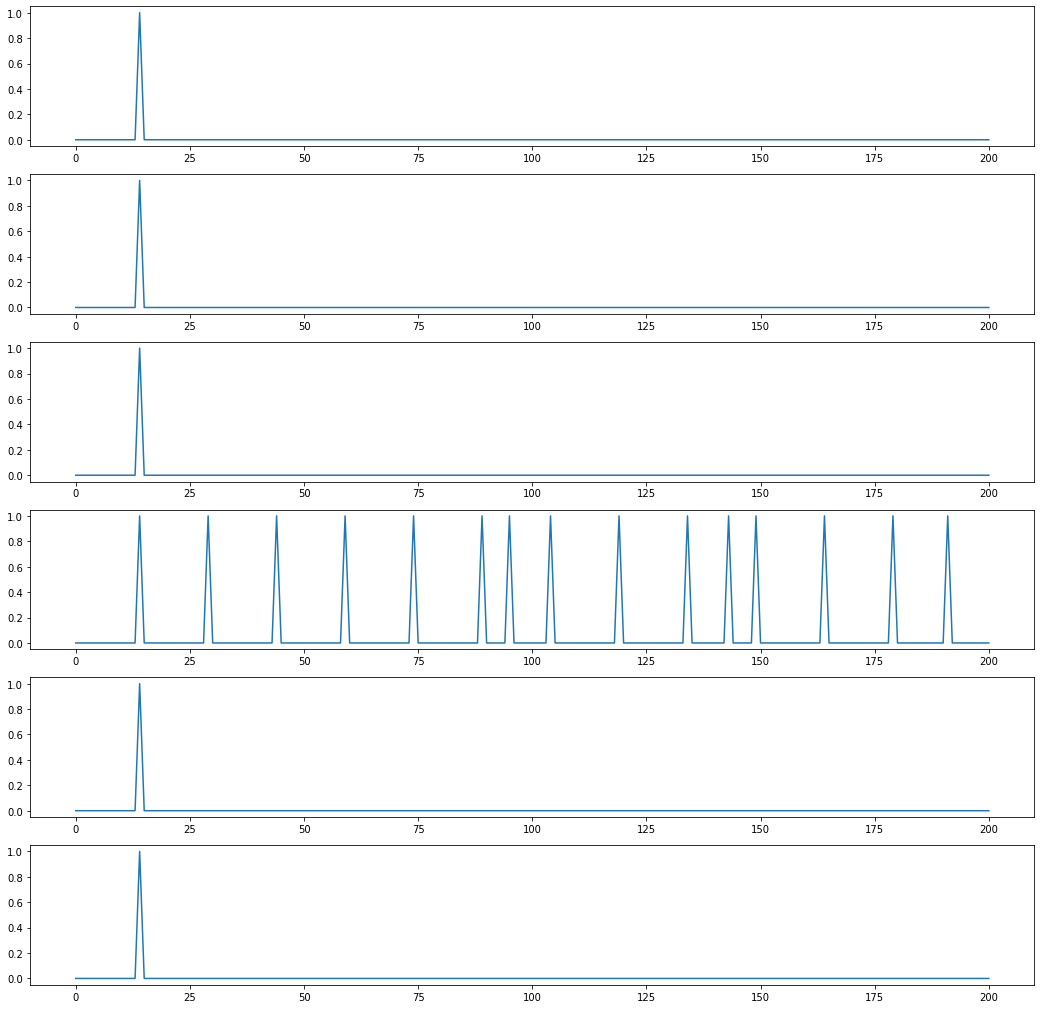

In [5]:
epoch = 3
idx = 5
fig = plt.figure(figsize=(18,3*n2))
axes=[]
for i in range(n2):
    axes.append(fig.add_subplot(n2,1,i+1))
    axes[i].plot(epoch_output[epoch-1][idx][i,:])

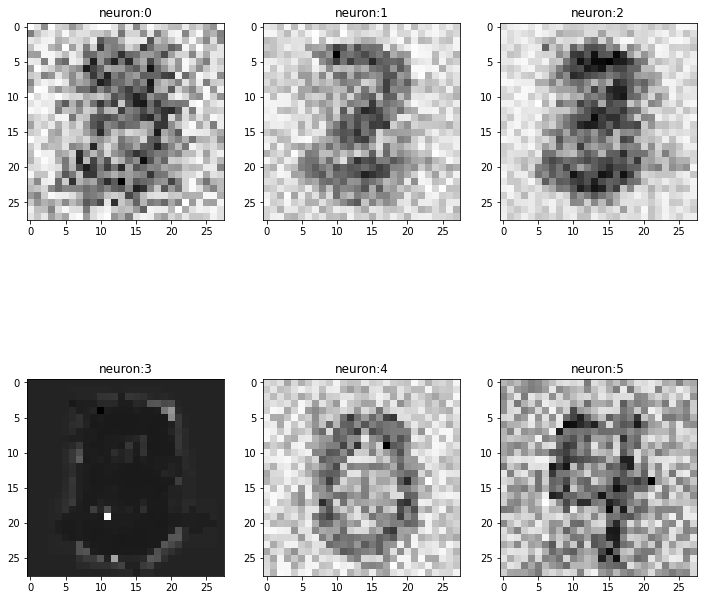

1.1393073268957652 -0.23432584448004284


In [6]:
fig = plt.figure(figsize=(12,12))
axes = []
row = 2
col = 3
max_ = np.max(synapse.weight)
min_ = np.min(synapse.weight)
for num in range(6):
    learned_img = np.interp(synapse.weight[:,num].reshape(28,28),[min_,max_],[0,255])
    axes.append(fig.add_subplot(row,col,num+1))
    axes[num].imshow(learned_img,cmap='Greys')
    axes[num].set_title(f"neuron:{num}")

plt.show()

print(max_, min_)
